<a href="https://colab.research.google.com/github/alejogiley/Hack7/blob/master/Unqualified_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Anaconda

In [0]:
#!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
#!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
#!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local

#!conda install -q -y --prefix /usr/local -c omnia --no-update-deps pdbfixer=1.4
#!conda install -q -y --prefix /usr/local -c conda-forge --no-update-deps xgboost=0.6a2
#!conda install -q -y --prefix /usr/local -c rdkit --no-update-deps rdkit=2017.09.1
#!conda install -q -y --prefix /usr/local -c deepchem --no-update-deps  deepchem-gpu=2.1.0

#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/')
#ignore warning about PYTHONPATH

In [0]:
import os
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Stats
from scipy.stats import skew

#Importing scikit-learn
import sklearn as sk
#Fill---
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.preprocessing import Imputer
#Normalizing
from sklearn import preprocessing
#Data split
from sklearn.model_selection import train_test_split 
#Random Forest packages
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import GridSearchCV
#Evaluation package
from sklearn.metrics import accuracy_score

#Importing XG_BOOST packages
import xgboost as xg
from xgboost import plot_importance

#Importing Neural Network Packages
from sklearn.neural_network import MLPClassifier

#Importing rdkit packages
from rdkit import RDConfig
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.ML.Descriptors import MoleculeDescriptors

#Importing DeepChem
import deepchem as dc

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# clean enviroment
lst = [df, pp, ps]
del lst
pp

In [222]:
# Load Dataset
df = pd.read_csv('/content/drive/My Drive/Hack 7/Gyrase/AZ_Pyrrolamides_4OE.csv', encoding='unicode_escape') 
df.head()

,External_ID,Molecule SMILES,First Sample Reg. Date,SAU Gyr IC50 (µM),SAU Gyr Ki (µM),Sau516 MIC (µg/ml),Sau516 MIC (µM),Mean Human Prot binding (% free),Mean LogD,Determination of pKa HA1,Determination of pKa HA2,Determination of pKa B1,Determination of pKa B2,Sirius pKa
0,AZ1001,c1cc(c(nc1)N2CCC(CC2)NC(=O)c3cc(c([nH]3)Cl)Cl)[N+](=O)[O-],6/10/2002,>400,NaN,>64,NaN,NaN,NV,NaN,NaN,NaN,NaN,NaN
1,AZ1002,CC(C)c1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)[N+](=O)[O-])Br,8/16/2002,>50,NaN,>64,NaN,NaN,>4,NaN,NaN,NaN,NaN,NaN
2,AZ1003,CCOC(=O)c1cc(nc(c1C#N)N2CCC(CC2)NC(=O)c3cc(c([nH]3)C)Br)C,8/16/2002,7.14,NaN,>64,NaN,NaN,>3.66,NaN,NaN,NaN,NaN,NaN
3,AZ1004,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3c(cccn3)C#N)Br,8/16/2002,9.93,NaN,>64,NaN,NaN,>3.13,NaN,NaN,NaN,NaN,NaN
4,AZ1005,Cc1c(cc([nH]1)C(=O)NC2CCN(CC2)c3ccc4ccccc4n3)Br,8/16/2002,3.31,NaN,>64,NaN,NaN,>4.07,NaN,NaN,NaN,NaN,NaN


In [0]:
# Get Smiles
pp['Smiles'] = df['Molecule SMILES']
pp['ProblematicSmiles'] = pd.Series()

# Flag bad smiles
def smile2mol(x):
  m = Chem.MolFromSmiles(x)
  if m is None:
    return None
  else:
    return m

# Get Mol objects 
pp['Molecule'] = pp['Smiles'].apply(lambda x: smile2mol(x))
pp['Molecule'][0]

# find index of problematic smiles
ps = [ k for k,v in enumerate(pp['Molecule']) if v is None ]

# Fix problematic smiles ??
if len(ps) > 0:
  print("Having problem getting structures for these smiles:")
  pp['ProblematicSmiles'] = pp['Smiles'].loc[ps]
  for i in range(len(ps)):
    print("index: %i" % ps[i], pp['ProblematicSmiles'].loc[ps[i]])

In [244]:
# Descriptors
descriptors = list(np.array(Descriptors._descList)[:,0])
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors) 

# Make is easier to identify problematic molecules later
# e.g infity descriptor values
def computeDescriptors(mol, calculator):
  res = np.array(calculator.CalcDescriptors(mol))
  if not np.all(np.isfinite(res)):
    return None 
  return res 

# Selecting only non-null molecules 
pp = pp[ pp["Molecule"].notnull() ]

# Mapping descriptors with molecules
pp['Descriptors'] = pp['Molecule'].map(lambda x: computeDescriptors(x, calculator)) 

# Flags problems
ps = pp["Descriptors"].isnull()
print("{} molecules failed to get descriptors".format(ps.sum())) 

# Rename columns
des = pp["Descriptors"].apply(pd.Series)
des = des.rename(columns = lambda x : descriptors[x])

0 molecules failed to get descriptors


In [258]:
# Concatenating main and descriptor dataframes
dataset = pd.concat([pp[["Molecule", "SAU Gyr IC50 (µM)"]], des], axis=1)
dataset = dataset.dropna(how ='any')
dataset[descriptors].head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.198481,-0.435597,12.198481,0.013283,0.623001,384.223,369.103,383.055195,132.0,0.0,0.311075,-0.350740,0.350740,0.311075,1.400000,2.120000,2.720000,1.606288,782.714558,17.974327,13.037493,14.549351,11.952397,7.646576,8.402505,5.682961,6.468125,4.062271,4.755185,2.799838,3.112547,-2.32,5.332598e+05,17.501340,7.283006,3.853433,152.831853,15.200677,10.847038,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,23.201880,24.974377,31.394564,9.945944,9.717848,40.614309,0.000000,15.284746,0.0,18.883484,17.989423,50.379934,0.0,0.000000,10.216698,11.505249,0.0,23.201880,39.929801,0.000000,10.114318,23.330108,24.395945,10.175743,0.000000,0.0,104.16,4.923311,14.908855,0.0,22.789517,42.465580,0.000000,18.329578,6.066367,4.899910,15.284746,23.201880,0.0,11.639059,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,54.916497,0.333333,25.0,2.0,8.0,0.0,1.0,1.0,0.0,2.0,2.0,5.0,2.0,10.0,4.0,0.0,1.0,1.0,3.0,3.02350,94.4053,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.517532,-0.411106,12.517532,0.011515,0.550709,436.310,414.134,435.090602,144.0,0.0,0.311075,-0.353241,0.353241,0.311075,1.444444,2.148148,2.740741,1.607439,843.272683,19.551677,15.236879,16.822875,12.863081,8.900969,9.693967,6.937354,7.791691,4.712163,5.368251,3.261192,4.047073,-2.42,1.314876e+06,19.344590,8.077319,4.292290,165.187695,15.200677,5.693928,0.0,5.817863,5.90718,5.

In [0]:
# Drop IPC!!!!
dataset = datset.drop(['Ipc'], axis=1)

# Drop empty columns
for col in dataset.

# Create correlation matrix
corr_matrix = dataset.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
for col in to_drop:
    dataset.drop(col, axis=1, inplace=True)
    
# Update descriptors


,Molecule,SAU Gyr IC50 (µM),MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,BalabanJ,BertzCT,HallKierAlpha,Ipc,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,RingCount,MolLogP,fr_Al_COO,fr_Al_OH,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,"<img src="""" alt=""Mol""/>",>400,12.198481,-0.435597,0.013283,0.623001,384.223,0.0,0.311075,-0.350740,1.400000,2.120000,1.606288,782.714558,-2.32,5.332598e+05,3.853433,15.200677,10.847038,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,23.201880,24.974377,31.394564,9.945944,9.717848,40.614309,0.000000,15.284746,0.0,18.883484,17.989423,50.379934,0.0,0.000000,10.216698,11.505249,0.0,23.201880,39.929801,0.000000,10.114318,23.330108,24.395945,10.175743,0.000000,0.0,104.16,4.923311,14.908855,0.0,22.789517,42.465580,0.000000,18.329578,6.066367,4.899910,15.284746,23.201880,0.0,11.639059,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,54.916497,0.333333,2.0,8.0,0.0,1.0,1.0,0.0,2.0,2.0,5.0,10.0,4.0,0.0,3.0,3.02350,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"<img src="""" alt=""Mol""/>",>50,12.517532,-0.411106,0.011515,0.550709,436.310,0.0,0.311075,-0.353241,1.444444,2.148148,1.607439,843.272683,-2.42,1.314876e+06,4.292290,15.200677,5.693928,0.0,5.817863,5.90718,5.687386,14.908855,4.983979,0.000000,0.0,13.847474,46.822227,41.561212,4.923311,9.717848,33.342373,0.000000,15.284746,0.0,38.648865,17.989423,50.370839,0.0,0.000000,10.216698,11.505249,0.0,15.929944,39.929801,0.000000,10.114318,48.789417,28.868664,0.000000,0.000000,0.0,104.16,4.923311,14.908855,0.0,17.636407,43.360853,10.166648,6.066367,18.329578,4.899910,45.062164,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.902714,62.030467,0.444444,2.0,8.0,0.0,1.0,1.0,0.0,2.0,2.0,5.0,9.0,5.0,0.0,3.0,3.60260,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
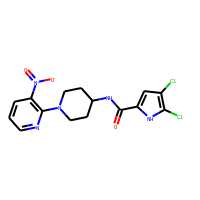
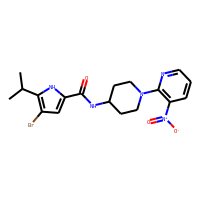
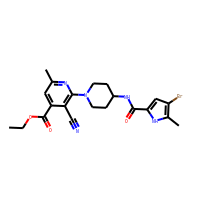
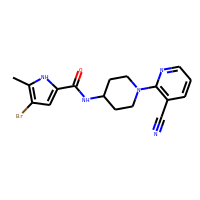
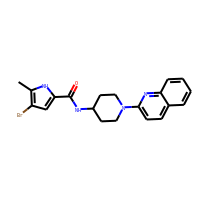

In [204]:
dataset.head()

For now ignore the qualifiers

In [0]:
# comment this latter
y = dataset['SAU Gyr IC50 (µM)'].str.replace('>', '', regex=True)
y = y.str.replace('<', '', regex=True)
#---------------------
dataset['SAU Gyr IC50 (µM)'] = y

# save in Google Drive
dataset.to_csv('/content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv')

# input & output
#X = dataset.drop('SAU Gyr IC50 (µM)',axis=1)
#Y = y

In [0]:
#data split into train test and validation
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

Convert to deepchem dataset

In [206]:
dataset_file = "/content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv"

user_specified_features = descriptors
featurizer = dc.feat.UserDefinedFeaturizer(user_specified_features)

loader = dc.data.UserCSVLoader(
      tasks=["Class"], smiles_field="Molecule", id_field="Molecule",
      featurizer=featurizer)

dc_set = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from /content/drive/My Drive/Hack 7/Gyrase/AZ_clean_test.csv
Loading shard 1 of size 8192.


KeyError: ignored

Normalize it to have zero-mean and unit-standard-deviation

In [188]:
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=Y_train),
    dc.trans.ClippingTransformer(transform_X=True, dataset=Y_train)]

datasets = [X_train, X_test, Y_train, Y_test]

for i, dataset in enumerate(datasets):
  for transformer in transformers:
      datasets[i] = transformer.transform(dataset)
      
X_train, X_test, Y_train, Y_test = datasets

AttributeError: ignored

In [194]:
c = dc.data.datasets(Y.train)

AttributeError: ignored